In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import requests
import time
import shapely
import json
import math
import re
from shapely.geometry import asShape
from collections import defaultdict

In [4]:
data_path = 'nyc-accessibility/elevator-pipeline/data/'

## Read in Data

In [5]:
df = pd.read_csv('CleanedNYCAccessibleTwitterData.csv', parse_dates = [6, 8])
df.head()

,name,human_eq_type,location,serving,status,date,status2,date2,time_spent,nyca_id
0,125th St,An elevator,NaN,Mezzanine And Downtown,FIXED,2017-03-14 18:28:41,nan,NaN,nan,400
1,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-15 12:18:12,FIXED,2017-03-15 13:08:33,0 days 00:50:21.000000000,400
2,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-29 03:38:37,FIXED,2017-03-29 09:09:04,0 days 05:30:27.000000000,400
3,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-30 18:28:44,FIXED,2017-03-30 21:58:46,0 days 03:30:02.000000000,400
4,125th St,An elevator,NaN,Mezzanine And Uptown,OUTAGE,2017-03-21 18:09:13,FIXED,2017-03-22 00:58:46,0 days 06:49:33.000000000,400


## Clean Data

### Format data

In [6]:
df['time_spent'] = pd.to_timedelta(df['time_spent'])
df.head()

,name,human_eq_type,location,serving,status,date,status2,date2,time_spent,nyca_id
0,125th St,An elevator,NaN,Mezzanine And Downtown,FIXED,2017-03-14 18:28:41,nan,NaN,NaT,400
1,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-15 12:18:12,FIXED,2017-03-15 13:08:33,00:50:21,400
2,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-29 03:38:37,FIXED,2017-03-29 09:09:04,05:30:27,400
3,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-30 18:28:44,FIXED,2017-03-30 21:58:46,03:30:02,400
4,125th St,An elevator,NaN,Mezzanine And Uptown,OUTAGE,2017-03-21 18:09:13,FIXED,2017-03-22 00:58:46,06:49:33,400


In [7]:
df.dtypes

name                      object
human_eq_type             object
location                  object
serving                   object
status                    object
date                      object
status2                   object
date2                     object
time_spent       timedelta64[ns]
nyca_id                    int64
dtype: object

In [8]:
# remove time spent
df['time_spent'].fillna(0, inplace = True)

### If status = 'FIXED' (meaning we do not have earlier outage data) drop it

In [9]:
df = df[df['status'] != 'FIXED']
df.head()

,name,human_eq_type,location,serving,status,date,status2,date2,time_spent,nyca_id
1,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-15 12:18:12,FIXED,2017-03-15 13:08:33,00:50:21,400
2,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-29 03:38:37,FIXED,2017-03-29 09:09:04,05:30:27,400
3,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-30 18:28:44,FIXED,2017-03-30 21:58:46,03:30:02,400
4,125th St,An elevator,NaN,Mezzanine And Uptown,OUTAGE,2017-03-21 18:09:13,FIXED,2017-03-22 00:58:46,06:49:33,400
5,125th St,An elevator,NaN,Mezzanine And Uptown,OUTAGE,2017-03-30 04:18:39,FIXED,2017-03-30 09:38:27,05:19:48,400


### Keep only elevator

In [10]:
df['human_eq_type'].value_counts()

An escalator    988
An elevator     473
Name: human_eq_type, dtype: int64

In [11]:
df = df[df['human_eq_type'] == 'An elevator']
df['human_eq_type'].value_counts()

An elevator    473
Name: human_eq_type, dtype: int64

## Create Necessary Columns

In [12]:
# Calculate minute spent fixing
df['time_spent_min'] = df['time_spent'].apply(lambda x: x.seconds / 60).astype(int)
df.head()

,name,human_eq_type,location,serving,status,date,status2,date2,time_spent,nyca_id,time_spent_min
1,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-15 12:18:12,FIXED,2017-03-15 13:08:33,00:50:21,400,50
2,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-29 03:38:37,FIXED,2017-03-29 09:09:04,05:30:27,400,330
3,125th St,An elevator,NaN,Mezzanine And Downtown,OUTAGE,2017-03-30 18:28:44,FIXED,2017-03-30 21:58:46,03:30:02,400,210
4,125th St,An elevator,NaN,Mezzanine And Uptown,OUTAGE,2017-03-21 18:09:13,FIXED,2017-03-22 00:58:46,06:49:33,400,409
5,125th St,An elevator,NaN,Mezzanine And Uptown,OUTAGE,2017-03-30 04:18:39,FIXED,2017-03-30 09:38:27,05:19:48,400,319


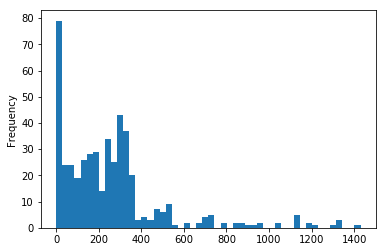

In [13]:
df['time_spent_min'].plot.hist(bins = 50)

In [14]:
def top_code600(val):
    if val > 600: 
        val = 600
    return val

In [15]:
# top code at 600
df['time_spent_min'] = df['time_spent_min'].apply(top_code600)

In [16]:
# Check how many has 0?
sum(df['time_spent_min'] == 0)

69

In [17]:
zero_spent = df[df['time_spent_min'] == 0]
zero_spent.head()

,name,human_eq_type,location,serving,status,date,status2,date2,time_spent,nyca_id,time_spent_min
29,14th St - 8 Av,An elevator,NaN,Mezzanine To L Platform,OUTAGE,2017-04-01 12:48:23,nan,NaN,0 days,445,0
58,161st St - Yankee Stadium,An elevator,NaN,Mezzanines To Downtown 4 Platform,OUTAGE,2017-03-22 15:10:06,nan,NaN,0 days,291,0
65,161st St - Yankee Stadium,An elevator,NE corner of 161st Street and River Avenue,Street To Mezzanine,OUTAGE,2017-04-01 06:18:47,nan,NaN,0 days,291,0
108,168th St,An elevator,NaN,Lower Mezzanine To Upper Mezzanine,OUTAGE,2017-03-27 10:38:21,nan,NaN,0 days,133,0
109,168th St,An elevator,NaN,Lower Mezzanine To Upper Mezzanine,OUTAGE,2017-03-27 10:38:21,nan,NaN,0 days,133,0


These are not fixed. Confirm this, and assign 600.

In [18]:
zero_spent['status2'].value_counts()

nan    69
Name: status2, dtype: int64

In [19]:
zero_spent[zero_spent['status2'] == 'FIXED']

,name,human_eq_type,location,serving,status,date,status2,date2,time_spent,nyca_id,time_spent_min


These are fixed within 1-2 seconds???   
We will mark these as 1

In [20]:
df.loc[(df['status2'] == 'FIXED') & (df['time_spent_min'] == 0), 'time_spent_min'] = 1

In [21]:
# For the rest, mark as 600
df.loc[(df['status2'] != 'FIXED') & (df['time_spent_min'] == 0), 'time_spent_min'] = 600

In [22]:
# check the distribution
df['time_spent_min'].describe()

count    473.000000
mean     313.158562
std      190.880693
min        8.000000
25%      159.000000
50%      289.000000
75%      500.000000
max      600.000000
Name: time_spent_min, dtype: float64

In [23]:
time_spent_df = df[['nyca_id', 'time_spent_min']].groupby('nyca_id').mean()
time_spent_df.head()

,time_spent_min
nyca_id,
1,311.000000
3,600.000000
8,223.166667
10,449.625000
14,456.333333


In [24]:
time_spent_dict = time_spent_df.to_dict()['time_spent_min']
time_spent_dict

{1: 311.0,
 3: 600.0,
 8: 223.16666666666666,
 10: 449.625,
 14: 456.33333333333331,
 34: 289.66666666666669,
 35: 155.59999999999999,
 41: 249.5,
 49: 275.13333333333333,
 57: 328.09090909090907,
 59: 250.0,
 67: 280.0,
 69: 600.0,
 72: 447.80000000000001,
 82: 39.0,
 84: 365.27272727272725,
 105: 600.0,
 110: 600.0,
 114: 475.0,
 133: 280.09090909090907,
 135: 287.5,
 163: 329.0,
 178: 360.90909090909093,
 194: 548.33333333333337,
 219: 600.0,
 223: 400.0,
 225: 85.0,
 226: 175.66666666666666,
 227: 600.0,
 241: 279.71428571428572,
 250: 247.59999999999999,
 253: 273.39999999999998,
 256: 140.0,
 262: 503.33333333333331,
 269: 234.8235294117647,
 276: 600.0,
 277: 600.0,
 283: 236.16666666666666,
 291: 286.72413793103448,
 294: 209.55555555555554,
 305: 277.0,
 315: 282.88888888888891,
 331: 600.0,
 347: 201.45454545454547,
 350: 230.0,
 352: 209.0,
 353: 69.5,
 354: 272.9375,
 359: 307.0,
 360: 452.25,
 363: 229.0,
 369: 103.59999999999999,
 373: 290.44444444444446,
 400: 333.111111

## Get neighborhood

In [25]:
# Start by reloading our core datasets:
with open('{}neighborhood_to_stations.json'.format(data_path)) as infile:
    neighborhood_to_stations=json.load(infile)
with open('{}stations_to_neighborhoods.json'.format(data_path)) as infile:
    stations_to_neighborhoods=json.load(infile)
with open('{}mta_stations_sorted_by_name.json'.format(data_path)) as infile:
    mta_stations_sorted_by_name=json.load(infile)
with open('{}nyca_stations.json'.format(data_path)) as infile:
    nyca_stations=json.load(infile)
with open('{}all_nyca_station_details.json'.format(data_path)) as infile:
    all_nyca_station_details=json.load(infile)
with open('{}neighborhood_data.json'.format(data_path)) as infile:
    neighborhood_data=json.load(infile)

In [26]:
mta_sorted = sorted([
    (m['properties']['name'],m['properties']['line'],m['properties']['objectid'])
    for m in mta_stations_sorted_by_name
])
nyca_sorted = sorted([
    (n['name'],tuple(n['lines']),n['id'])
    for n in nyca_stations
]) 

In [27]:
pd.DataFrame(mta_sorted).to_csv('mta_sorted.csv')
pd.DataFrame(nyca_sorted).to_csv('nyca_sorted.csv')
dr1=pd.DataFrame.from_csv('{}aligned_mta_nyca.csv'.format(data_path))

In [28]:
# tuple of (mta,nyca_id)
def format_mta_id(flt):
    if not flt or math.isnan(flt):
        return None
    else:
        return str(int(flt))

def format_nyca_id(flt):
    if not flt or math.isnan(flt):
        return None
    else:
        return int(flt)

aligned_objectids = [
    (format_mta_id(r[3]),format_nyca_id(r[7]))
    for r in dr1.to_records()
]
mta_stations_to_name={ms['properties']['objectid']:ms['properties']['name'] for ms in mta_stations_sorted_by_name}
nyca_stations_to_name={ns['id']:ns['name'] for ns in nyca_stations}
first_rec=aligned_objectids[0]
(mta_stations_to_name[first_rec[0]],nyca_stations_to_name[first_rec[1]]) # confirming they match

('103rd St', '103rd St')

In [29]:
nyca_station_to_ntacode=defaultdict(lambda:set())
#aligned_objectids[0][1]
#stations_to_neighborhoods[aligned_objectids[0][0]]
for mta_id,nyca_id in aligned_objectids:
    if mta_id is None:
        print('Missing mta_id for nyca_id {}'.format(nyca_id))
    elif nyca_id is None:
        print('Missing nyca_id for mta_id {}'.format(mta_id))
    elif mta_id in stations_to_neighborhoods:
        neighborhoods=stations_to_neighborhoods[mta_id]
        if len(neighborhoods) == 1:
            nyca_station_to_ntacode[nyca_id].add(neighborhoods[0])
        else:
            print('Multi-neighborhood data for {}/{}'.format(mta_id,nyca_id))
    else:
        print('Missing neighborhood data for {}'.format(mta_id))

ntacode_to_name={nb['properties']['NTACode']:nb['properties']['NTAName'] for nb in neighborhood_data['features']}
for nyca_id,ntacodes in nyca_station_to_ntacode.items():
    if len(ntacodes) != 1:
        print('NYCA id {} ({}) maps to neighborhoods {}'.format(
            nyca_id,
            nyca_stations_to_name[nyca_id],
            [ntacode_to_name[nb] for nb in ntacodes]))

Missing mta_id for nyca_id 372
Missing nyca_id for mta_id 470
Missing nyca_id for mta_id 442
Missing nyca_id for mta_id 641
Missing nyca_id for mta_id 642
Missing nyca_id for mta_id 443
Missing nyca_id for mta_id 643
Missing nyca_id for mta_id 153
Missing nyca_id for mta_id 371
NYCA id 34 (Union Sq - 14th St) maps to neighborhoods ['West Village', 'Hudson Yards-Chelsea-Flatiron-Union Square']
NYCA id 49 (Atlantic Ave) maps to neighborhoods ['Park Slope-Gowanus', 'Fort Greene']
NYCA id 57 (Borough Hall) maps to neighborhoods ['Brooklyn Heights-Cobble Hill', 'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill']
NYCA id 274 (Broadway Junction) maps to neighborhoods ['Bushwick South', 'Ocean Hill']
NYCA id 471 (Grand Central - 42nd St) maps to neighborhoods ['Murray Hill-Kips Bay', 'Turtle Bay-East Midtown', 'Midtown-Midtown South']


In [30]:
def station_scores_to_neighborhood_data(station_scores):
    neighborhood_scores=defaultdict(lambda:0)
    for station_id,station_score in station_scores.items():
        for neighborhood in nyca_station_to_ntacode[int(station_id)]:
            neighborhood_scores[neighborhood] = neighborhood_scores[neighborhood]+station_score    
    return dict(neighborhood_scores)

In [31]:
time_spent_scores = station_scores_to_neighborhood_data(time_spent_dict)
time_spent_scores

{'BK09': 328.09090909090907,
 'BK23': 369.66666666666669,
 'BK28': 282.88888888888891,
 'BK37': 275.13333333333333,
 'BK38': 431.69090909090903,
 'BK41': 249.5,
 'BK42': 600.0,
 'BK44': 600.0,
 'BK61': 657.35555555555561,
 'BK68': 525.13333333333333,
 'BK77': 360.90909090909093,
 'BK78': 290.44444444444446,
 'BK82': 301.0,
 'BK95': 280.0,
 'BX05': 506.60000000000002,
 'BX10': 329.0,
 'BX17': 600.0,
 'BX27': 1049.625,
 'BX29': 273.39999999999998,
 'BX34': 236.16666666666666,
 'BX44': 726.5,
 'BX49': 279.71428571428572,
 'BX63': 286.72413793103448,
 'MN01': 140.0,
 'MN11': 333.11111111111109,
 'MN12': 600.0,
 'MN13': 646.45238095238096,
 'MN14': 872.9375,
 'MN17': 2043.5505050505051,
 'MN19': 789.58333333333337,
 'MN20': 150.58333333333334,
 'MN23': 600.66666666666674,
 'MN24': 586.74285714285713,
 'MN31': 69.5,
 'MN34': 218.22222222222223,
 'MN35': 600.0,
 'MN36': 567.59090909090901,
 'MN40': 209.0,
 'QN15': 548.33333333333337,
 'QN17': 400.0,
 'QN29': 155.59999999999999,
 'QN31': 733.3

In [32]:
# And, once again, enrich the original neighborhood_data geojson with neighborhood_score:
for n in neighborhood_data['features']:
    n_id=n['properties']['NTACode']
    n['properties']['elevator_outage_score'] = time_spent_scores.get(n_id,0)

#... and write it back out:
with open('time_spent_scores.json','w') as outfile:
    json.dump(neighborhood_data,outfile)

In [ ]:
# create a flag for 'OUTAGE'
df['broken'] = pd.get_dummies(df['status'])['OUTAGE']
df[['status', 'broken']].head()

In [ ]:
num_broken_df = df[['nyca_id', 'broken']].groupby('nyca_id').sum()
num_broken_df.head()

In [ ]:
num_broken_df.describe()

In [ ]:
num_broken_dict = num_broken_df.to_dict()['broken']
num_broken_dict

In [ ]:
num_broken_df.reset_index().head()